In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

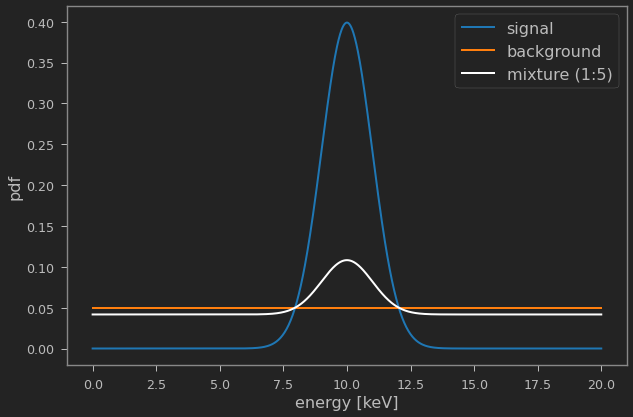

In [11]:
fig, ax = plt.subplots(figsize=(9, 6)) 

e_min = 0
e_max = 20

x_vals = np.linspace(e_min, e_max, 1000)

mu = 10
sigma = 1
signal_pdf_vals = norm.pdf(x_vals, mu, sigma)
bkg_pdf_vals = uniform.pdf(x_vals, e_min, e_max)

lambda_s = 200
lambda_b = 1000
pdf_vals = lambda_s/(lambda_s+lambda_b) * norm.pdf(x_vals, mu, sigma) + lambda_b/(lambda_s+lambda_b) * uniform.pdf(x_vals, e_min, e_max)

ax.plot(x_vals, signal_pdf_vals, linewidth=2, color='tab:blue', label='signal')
ax.plot(x_vals, bkg_pdf_vals, linewidth=2, color='tab:orange', label='background')
ax.plot(x_vals, pdf_vals, linewidth=2, color='white', label='mixture (1:5)')

ax.set_xlabel("energy [keV]", fontsize=16)
ax.set_ylabel("pdf", fontsize=16)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()


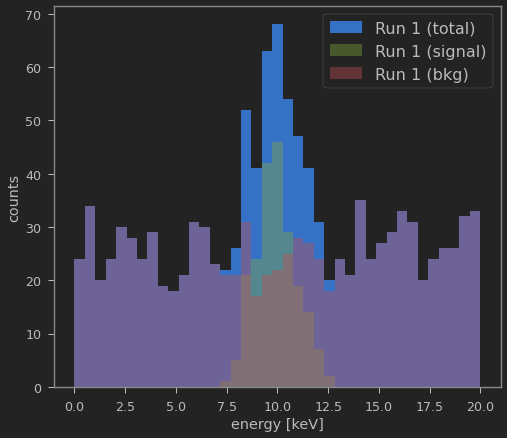

In [12]:
mu = 10
sigma = 1
x_min = 0
x_max = 20

rv_seed = 0
np.random.seed(rv_seed)

ntot = np.random.poisson(lambda_s + lambda_b)

# First step generate random numbers between 0 and 1 and attribute each
# event to signal or background using based on the ratio between
# signal rate and total rate
alpha = lambda_s / (lambda_s + lambda_b)
temp_rvars = np.random.uniform(0,1, ntot)
idx_s = np.where(temp_rvars < alpha)[0]
idx_b = np.where(temp_rvars >= alpha)[0]

# Second step. Store in "samples" the energy value of each event
samples = np.zeros(ntot)
# draw samples that are realized as background events from the background distribution 
samples[idx_b] = np.random.uniform(x_min, x_max, len(idx_b))
# draw samples that are realized as signal events from the signal distribution 
samples[idx_s] = np.random.normal(mu, sigma, len(idx_s))

bin_edges = np.linspace(x_min, x_max, 40)
plt.hist(samples, bins=bin_edges, label="Run 1 (total)")
plt.hist(samples[idx_s], bins=bin_edges, label="Run 1 (signal)", alpha=0.4)
plt.hist(samples[idx_b], bins=bin_edges, label="Run 1 (bkg)", alpha=0.4)
plt.xlabel("energy [keV]")
plt.ylabel("counts")
plt.legend(fontsize=16)
plt.show()

In [20]:
def class_prob(c, pars):
    lambda_s, lambda_b = (pars['lambda_s'], pars['lambda_b'])
    lambda_tot = lambda_s + lambda_b
    
    if c == 0:
        return lambda_b / lambda_tot
    
    elif c == 1:
        return lambda_s / lambda_tot
    
    else:
        raise ValueError(f"ValueError: c can only be 0 or 1. but value c={c} given.")

pars = {'lambda_s': lambda_s, 'lambda_b': lambda_b}

print(class_prob(0, pars))
print(class_prob(1, pars))

0.8333333333333334
0.16666666666666666


In [21]:
def conditional_energy_pdf(energy, c, pars):
    
    if c == 0:
        return uniform.pdf(energy, pars['emin'], pars['emax'])
    
    elif c == 1:
        return norm.pdf(energy, pars['mu'], pars['sigma'])
    
    else:
        raise ValueError(f"ValueError: c can only be 0 or 1. but value c={c} given.")
    
pars.update({'emin':0., 'emax':20., 'mu':10., 'sigma':1.})

print(conditional_energy_pdf(10, 0, pars))
print(conditional_energy_pdf(10, 1, pars))

0.05
0.3989422804014327


In [22]:
def joint_pdf(energy , c, pars):
    if c == 0 or c == 1:
        return conditional_energy_pdf(energy, c, pars) * class_prob(c, pars)
    else:
        raise ValueError(f"ValueError: c can only be 0 or 1. but value c={c} given.") 
        
print(joint_pdf(10, 0, pars))
print(joint_pdf(10, 1, pars))

0.04166666666666667
0.06649038006690544


In [23]:
def class_prob_given_energy(c, energy, pars):
    if c == 0 or c == 1:
        p_joint = joint_pdf(energy, c, pars)
        
        
        p_marginal = 0
        for c in [0, 1]:
            p_marginal += joint_pdf(energy, c, pars)
            
        return p_joint / p_marginal
        
    else:
        raise ValueError(f"ValueError: c can only be 0 or 1. but value c={c} given.") 
    
p0 = class_prob_given_energy(0, 10, pars)
p1 = class_prob_given_energy(1, 10, pars)
print(p0, p1, p0+p1)

0.3852422743134431 0.614757725686557 1.0


In [24]:
energies = np.linspace(0.0, 20.0, 1000)
background_probs = class_prob_given_energy(0, energies, pars) 
signal_probs = class_prob_given_energy(1, energies, pars)




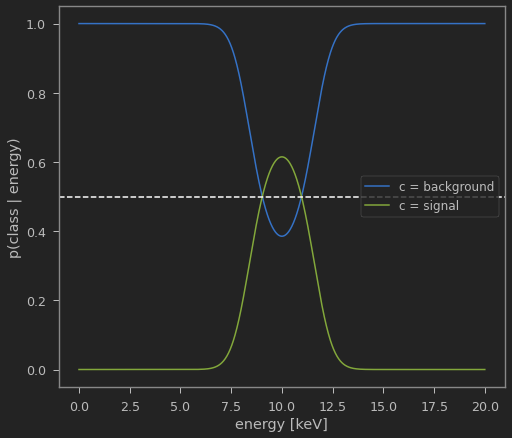

In [25]:
plt.plot(energies, background_probs, label='c = background')
plt.plot(energies, signal_probs, label='c = signal')
plt.axhline(0.5, color='white', linestyle='dashed')

plt.xlabel("energy [keV]")
plt.ylabel("p(class | energy)")
plt.legend(fontsize=12)

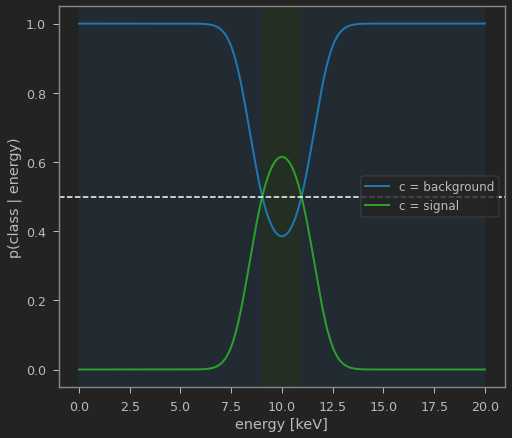

In [26]:
energies = np.linspace(0.0, 20.0, 1000)
background_probs = class_prob_given_energy(0, energies, pars) 
signal_probs = class_prob_given_energy(1, energies, pars)

# get a decision boundary
idx = background_probs < 0.5
boundary_idx = np.where(np.diff(np.array(idx, dtype=int))!=0)[0]

boundary_low = energies[boundary_idx[0]]
boundary_high = energies[boundary_idx[1]]

plt.plot(energies, background_probs, label='c = background', color='tab:blue', linewidth=2)
plt.plot(energies, signal_probs, label='c = signal', color='tab:green', linewidth=2)

plt.axvspan(pars['emin'], boundary_low, color='tab:blue', alpha=0.1)
plt.axvspan(boundary_high, pars['emax'], color='tab:blue', alpha=0.1)
plt.axvspan(boundary_low, boundary_high, color='tab:green', alpha=0.1)
plt.axhline(0.5, color='white', linestyle='dashed')

plt.xlabel("energy [keV]")
plt.ylabel("p(class | energy)")
plt.legend(fontsize=12)

In [27]:
print(boundary_low, boundary_high)

9.02902902902903 10.95095095095095
